In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pingouin as pg

In [2]:
def stampToTime(x):
    l = x.split(' ')[1]
    ts = l.split(':')
    t = float(ts[0])*3600 + float(ts[1])*60 + float(ts[2])
    return t

In [3]:
def cut_window(gs,vys,ts):
    
    start_t = 0
    for g,t in zip(gs,ts): 
        if g == -50: 
            start_t = t - 3.5
            break
            
    ng = []; nvy = []; nt = []
    for i,[g,vy,t] in enumerate(zip(gs,vys,ts)):
        if t > start_t + 3.5 and g == 50: break
        if t > start_t: ng.append(g); nvy.append(vy); nt.append(t)
            
    return ng,nvy,nt

def norm_time(data):
    data["timestamp"] = data["timestamp"].apply(lambda x: stampToTime(x))
    data["timestamp"] = data["timestamp"] - data.iloc[0]["timestamp"]
    return data

def getVy(data):
    vys = []; ts = []; e = []; gs = []
    for y, ym, t, tm, g in zip(data[" y"][1:],\
                            data[" y"][0:-1],\
                            data["timestamp"][1:],\
                            data["timestamp"][0:-1],\
                            data[" goalVy"][1:]):
        dy = float(y)-float(ym)
        dt = float(t)-float(tm)
        if dt > 0 and abs(dy/dt) < 185 and g != 0:
            ts.append(t)
            if len(vys) != 0: vys.append(0.5*vys[-1] + 0.5*dy/dt)
            else: vys.append(dy/dt)
            e.append(abs(vys[-1]-float(g)))
            gs.append(float(g))
    return ts,vys,e,gs

In [4]:
def process_error(data):
    data = norm_time(data.copy())
    t,vy,e,g = getVy(data)
    gs,vys,t = cut_window(g,vy,t)
    es = []
    for g,vy in zip(gs,vys):
        es.append(pow(g-vy,2))
    
    s = []
    for v in [50,-50,75,-75,100,-100,150,-150,185,-185]:
        w = []
        for g,e in zip(gs,es):
            if g == v: w.append(e)
        if len(w)==0:s.append(-1)
        else:s.append(np.sqrt(np.mean(w))/abs(v)*100)
            
    return s

In [5]:
def clean_ctrl(s): 
    if s.strip() not in ["old","adaptive"]: return "adaptive"
    else: return s.strip()
    
def clean_run(s):
    if type(s) == int: return s
    if s.strip() not in ["1","2","3"]: return "nan"
    else: return int(s.strip())
    
def clean_weight(s):
    if type(s) == int: return s
    if s.strip() not in ["0","50","100","150","200"]: return "nan"
    else: return int(s.strip())

file = "logs_Ubuntu_20.04.3_LTS_@_A0_A4_C5_91_5E_9B_Thu-17-02-2022_"
files = ["13_14_09","13_45_59","14_02_52","14_14_20",\
         "15_04_54","15_39_07","15_45_05"]

df = pd.DataFrame(columns=["Ctrl","Weight","Run","Err"])#50","Err75","Err100","Err150","Err185","Err-50","Err-75","Err-100","Err-150","Err-185"])

for f in files:
    
    data = pd.read_csv(file + f + ".csv")
    ctrl = ""
    run = 0
    weight = 0
    err = 0
    
    data[" controller"] = data[" controller"].apply(lambda x: clean_ctrl(x))
    data[" run#"] = data[" run#"].apply(lambda x: clean_run(x))
    data.drop(data[data[" run#"]=="nan"].index,inplace=True)
    data[" weight"] = data[" weight"].apply(lambda x: clean_weight(x))
    data.drop(data[data[" weight"]=="nan"].index,inplace=True)
    
    for c in data[" controller"].unique():
        if c.strip() == "old": ctrl = "Old"
        else: ctrl = "Adaptive"
            
        data_c = data[data[" controller"] == c]
        
        for w in data_c[" weight"].unique():
            weight = w
            
            data_w = data_c[data_c[" weight"] == w]
                
            for r in data_w[" run#"].unique():
                run = r
                
                data_r = data_w[data_w[" run#"] == r]
                
                err = process_error(data_r)
                
                #print(f,c,w,r,err)
                if err[8] == -1:continue
                if err[9] == -1:continue
                for i in range(0,10):
                    df = df.append({"Ctrl":c,"Weight":w, "Run" : r , "Err":err[i]},ignore_index=True)
                # df = df.append({"Ctrl":c,"Weight":w,"Run":r,"Err50":(err[0]),"Err-50":(err[1]),\
                #                 "Err75":(err[2]),"Err-75":np.sqrt(err[3]),"Err100":(err[4]), "Err-100":(err[5]),\
                #                 "Err150":(err[6]),"Err-150":(err[7]),"Err185":(err[8]),"Err-185":np.sqrt(err[9])},    
                #                ignore_index=True)
# df['average'] = (df.Err50+df.Err75 + df.Err100 + df.Err150 + df.Err185) / 5
df['average']=df[df.columns[3:]].mean(axis=1)
df[df.Weight==200]

,Ctrl,Weight,Run,Err,average
100,adaptive,200,3,88.919234,88.919234
101,adaptive,200,3,85.678948,85.678948
102,adaptive,200,3,79.534687,79.534687
103,adaptive,200,3,82.791263,82.791263
104,adaptive,200,3,84.025762,84.025762
...,...,...,...,...,...
745,adaptive,200,3,46.746916,46.746916
746,adaptive,200,3,89.061205,89.061205
747,adaptive,200,3,72.746983,72.746983
748,adaptive,200,3,67.243998,67.243998


old 53.43231954084735ada 51.6619064090409


MannwhitneyuResult(statistic=2179.0, pvalue=0.7139126686491302)

0.5188095238095238

old 54.50211003416851ada 53.74693743164239


MannwhitneyuResult(statistic=2849.0, pvalue=0.5688940897419501)

0.5275925925925926

old 63.007495899237604ada 58.14061210818242


MannwhitneyuResult(statistic=3437.0, pvalue=0.004722346656917067)

0.6364814814814815

old 70.36160245473427ada 65.16196833093422


MannwhitneyuResult(statistic=4315.0, pvalue=0.030148036742304915)

0.5993055555555555

old 77.48651948174187ada 71.34865578503421


MannwhitneyuResult(statistic=3048.0, pvalue=0.006401638372703008)

0.635

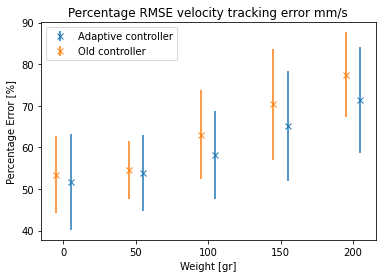

In [6]:
ada = np.zeros(5)
ada_std = np.zeros(5)
df_ada = df[df["Ctrl"] == "adaptive"]

old = np.zeros(5)
old_std = np.zeros(5)
df_old = df[df["Ctrl"] == "old"]
for i,w in enumerate([0,50,100,150,200]):
    df_ada_w = df_ada[df_ada["Weight"] == w]
    ada[i] = np.mean(df_ada_w.average)#["Err"+str(speeds[s])])
    ada_std[i] = np.std(df_ada_w.average)#["Err"+str(speeds[s])])
    
    df_old_w = df_old[df_old["Weight"] == w]
    old[i] = np.mean(df_old_w.average)#["Err"+str(speeds[s])])
    old_std[i] = np.std(df_old_w.average)#["Err"+str(speeds[s])])
    print("old "+str(old[i])+"ada "+str(ada[i]))
    display(stats.mannwhitneyu(df_old_w.average, df_ada_w.average))
    display(pg.compute_effsize(df_old_w.average, df_ada_w.average,eftype='cles'))
    
    

plt.errorbar([5,55,105,155,205],ada,ada_std,linestyle='None', marker='x', label="Adaptive controller")
plt.errorbar([-5,45,95,145,195],old,old_std,linestyle='None', marker='x', label="Old controller")
plt.title("Percentage RMSE velocity tracking error mm/s")
plt.legend(loc = "upper left")
plt.xlabel("Weight [gr]")
plt.ylabel("Percentage Error [%]")

plt.savefig('Tracking error.jpg',bbox_inches='tight', dpi=200)

plt.show()

[63.631211270572194, 61.57726129916322, 49.79035774327577, 60.77363361165368, 62.10862885701572, 56.5971681020391, 55.40908210668933, 66.8330773634178, 65.92912460123041, 60.6495716508596]


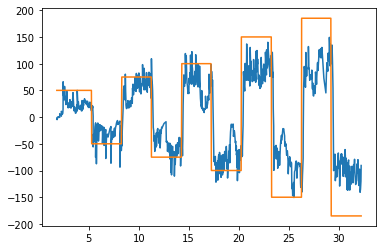

In [8]:
data = pd.read_csv(file + files[0] + ".csv")
data = data[data[" weight"] == "100"]
data = data[data[" run#"] == "1"]
print(process_error(data))
data = norm_time(data)
t,vy,e,g = getVy(data)
g,vy,t = cut_window(g,vy,t)
plt.plot(t,vy)
plt.plot(t,g)

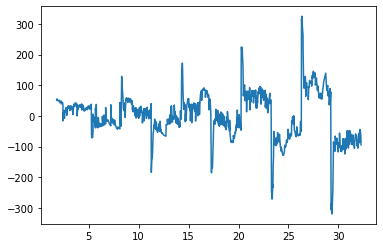

In [9]:
plt.plot(t,np.array(g)-np.array(vy))

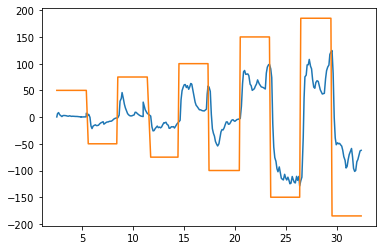

In [12]:
data1  = pd.read_csv(file + files[1] + ".csv")
data1[" controller"] = data1[" controller"].apply(lambda x: clean_ctrl(x))
data1[" run#"] = data1[" run#"].apply(lambda x: clean_run(x))
data1.drop(data1[data1[" run#"]=="nan"].index,inplace=True)
data1[" weight"] = data1[" weight"].apply(lambda x: clean_weight(x))
data1.drop(data1[data1[" weight"]=="nan"].index,inplace=True)
data1 = data1[data1[" weight"] == 150]
data1 = data1[data1[" run#"] == 1]
# print(process_error(data))
data1 = norm_time(data1)
t,vy,e,g = getVy(data1)
g,vy,t = cut_window(g,vy,t)
plt.plot(t,vy)
plt.plot(t,g)